In [ ]:
import os
import shutil
from PIL import Image
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.18.0


In [ ]:
nutrition_data = pd.read_csv('nutrition_dupe.csv')
nutrition_data.head()

,id,calories,proteins,fat,carbohydrate,name
0,1,280,9.2,28.4,0.0,Abon
1,2,0,0.0,0.2,0.0,Agar-agar
2,3,85,0.9,6.5,7.7,Alpukat segar
3,4,58,0.3,0.4,14.9,Apel
4,5,298,34.2,16.8,0.1,Ayam goreng kentucky dada


In [ ]:
image_folder_path = './food_image'

categories = nutrition_data['name'].unique()

# Fungsi untuk menghitung jumlah gambar
def count_images_for_category(category):
    category_path = os.path.join(image_folder_path, category)
    if os.path.exists(category_path):  
        images = [f for f in os.listdir(category_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
        print(f"There are {len(images)} images for the category '{category}'.")
    else:
        print(f"Folder for category '{category}' does not exist!")

# Hitung jumlah gambar untuk setiap kategori
for category in categories:
    count_images_for_category(category)

There are 5 images for the category 'Abon'.
There are 5 images for the category 'Agar-agar'.
There are 5 images for the category 'Alpukat segar'.
There are 5 images for the category 'Apel'.
There are 5 images for the category 'Ayam goreng kentucky dada'.


In [ ]:
print(nutrition_data.info())

if nutrition_data.isnull().sum().any():
    print("Data memiliki nilai kosong. Mengisi nilai kosong dengan 0...")
    nutrition_data.fillna(0, inplace=True)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_normalize = ['calories', 'proteins', 'fat', 'carbohydrate']
nutrition_data[columns_to_normalize] = scaler.fit_transform(nutrition_data[columns_to_normalize])


from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
nutrition_data['label'] = label_encoder.fit_transform(nutrition_data['name'])

X = nutrition_data[columns_to_normalize].values  # Fitur: nutrisi
y = nutrition_data['label'].values               # Label: nama makanan dalam format numerik

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data setelah preprocessing:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder disimpan sebagai 'label_encoder.pkl'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            5 non-null      int64  
 1   calories      5 non-null      int64  
 2   proteins      5 non-null      float64
 3   fat           5 non-null      float64
 4   carbohydrate  5 non-null      float64
 5   name          5 non-null      object 
dtypes: float64(3), int64(2), object(1)
memory usage: 368.0+ bytes
None
Data setelah preprocessing:
X_train shape: (4, 4)
X_test shape: (1, 4)
y_train shape: (4,)
y_test shape: (1,)
Label encoder disimpan sebagai 'label_encoder.pkl'


In [8]:
# Root directory for split data
root_dir = './food_split'

# Empty root directory if it already exists
if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

# Create train and validation directories
train_dir = os.path.join(root_dir, 'training')
validation_dir = os.path.join(root_dir, 'validation')

os.makedirs(train_dir)
os.makedirs(validation_dir)

In [9]:
# Function to create subdirectories for each food category
def create_train_val_dirs(food_name):
    train_food_dir = os.path.join(train_dir, food_name)
    validation_food_dir = os.path.join(validation_dir, food_name)

    os.makedirs(train_food_dir, exist_ok=True)
    os.makedirs(validation_food_dir, exist_ok=True)

# Create directories for all food categories in the dataset
categories = nutrition_data['name'].unique()
for category in categories:
    create_train_val_dirs(category)

In [10]:
# Function to split data into training and validation sets
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE=0.8):
    """
    Splits images in SOURCE_DIR into TRAINING_DIR and VALIDATION_DIR.
    """
    # List all image files in the source directory
    image_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(('.jpeg', '.jpg', '.png'))]

    # Shuffle and split data
    random.shuffle(image_files)
    split_index = int(len(image_files) * SPLIT_SIZE)
    train_files = image_files[:split_index]
    val_files = image_files[split_index:]

    # Copy files to respective directories
    for file_name in train_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(TRAINING_DIR, file_name)
        shutil.copyfile(src, dst)

    for file_name in val_files:
        src = os.path.join(SOURCE_DIR, file_name)
        dst = os.path.join(VALIDATION_DIR, file_name)
        shutil.copyfile(src, dst)

In [11]:
# Apply the split for each category
image_root = './food_image'
split_size = 0.8

for category in categories:
    source_dir = os.path.join(image_root, category)
    train_food_dir = os.path.join(train_dir, category)
    validation_food_dir = os.path.join(validation_dir, category)

    # Ensure the source directory exists
    if os.path.exists(source_dir):
        split_data(source_dir, train_food_dir, validation_food_dir, split_size)
        print(f"Processed category '{category}':")
        print(f"  - {len(os.listdir(train_food_dir))} images for training")
        print(f"  - {len(os.listdir(validation_food_dir))} images for validation")
    else:
        print(f"Warning: Source folder for category '{category}' not found.")

Processed category 'Abon':
  - 4 images for training
  - 1 images for validation
Processed category 'Agar-agar':
  - 4 images for training
  - 1 images for validation
Processed category 'Alpukat segar':
  - 4 images for training
  - 1 images for validation
Processed category 'Apel':
  - 4 images for training
  - 1 images for validation
Processed category 'Ayam goreng kentucky dada':
  - 4 images for training
  - 1 images for validation


**Image Augmentation**

In [12]:
# Directories for training and validation data
train_dir = './food_split/training'
validation_dir = './food_split/validation'

# Define ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,           # Normalize pixel values (0-255 -> 0-1)
    rotation_range=30,         # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,     # Randomly translate images horizontally by 20% of width
    height_shift_range=0.2,    # Randomly translate images vertically by 20% of height
    shear_range=0.2,           # Shear intensity (for slanted images)
    zoom_range=0.2,            # Randomly zoom in/out by 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill empty pixels after augmentation
)

# Define ImageDataGenerator for validation without augmentation
val_datagen = ImageDataGenerator(
    rescale=1.0/255            # Normalize pixel values
)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),    # Resize images to 150x150 pixels
    batch_size=32,             # Number of images per batch
    class_mode='categorical'   # Multiclass classification
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),    # Resize images to 150x150 pixels
    batch_size=32,             # Number of images per batch
    class_mode='categorical'   # Multiclass classification
)

Found 20 images belonging to 5 classes.
Found 5 images belonging to 5 classes.


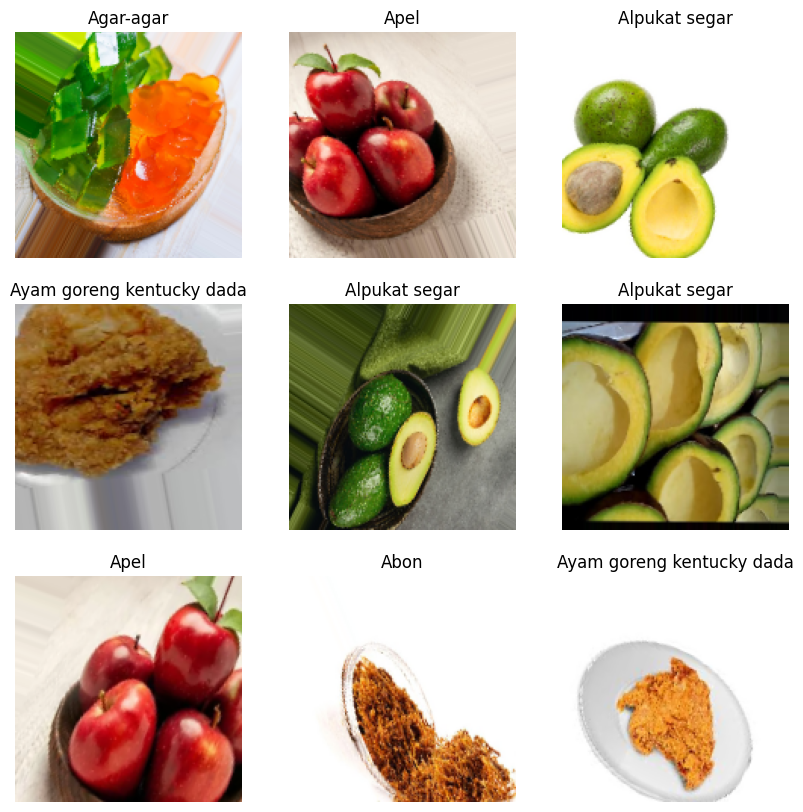

In [ ]:
images, labels = next(train_generator)

# Class names dari indeks di train_generator
class_names = list(train_generator.class_indices.keys())

# Plot 9 gambar pertama
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])  # Konversi dari one-hot ke nama kelas
    plt.axis("off")
plt.show()

In [14]:
# Definisi model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output sesuai jumlah kelas
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Menyimpan model
model.save('food_classification_model.keras')

C:\Users\valen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2500 - loss: 1.5984 - val_accuracy: 0.2000 - val_loss: 1.9385
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.1500 - loss: 2.1959 - val_accuracy: 0.2000 - val_loss: 1.9818
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.1500 - loss: 2.2077 - val_accuracy: 0.4000 - val_loss: 1.6131
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2000 - loss: 1.6649 - val_accuracy: 0.4000 - val_loss: 1.5583
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2500 - loss: 1.6294 - val_accuracy: 0.4000 - val_loss: 1.5447
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3500 - loss: 1.5407 - val_accuracy: 0.4000 - val_loss: 1.5165
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.4500 - loss: 1.5360 - val_accuracy: 0.4000 - val_loss: 1.4603
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.4355 - val_accuracy: 0.4000 - val_loss: 1.405

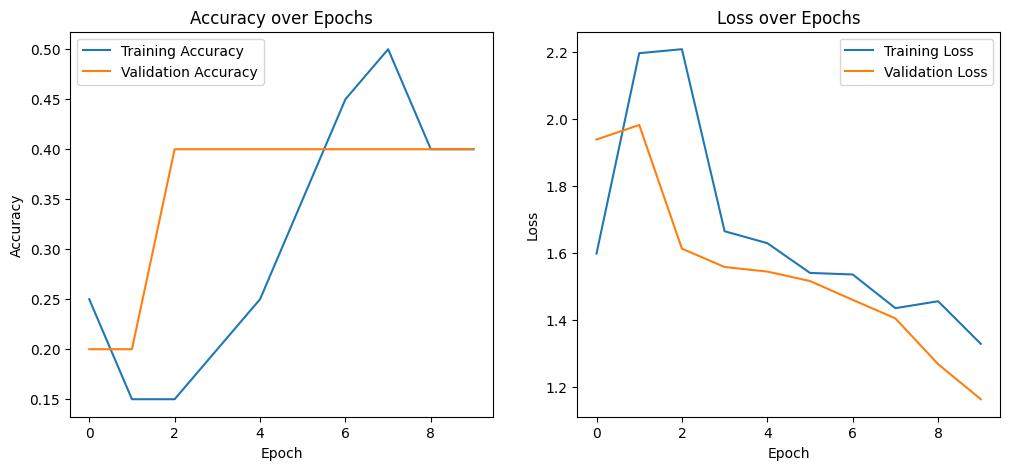

In [16]:
# Plot akurasi dan loss selama training
plt.figure(figsize=(12, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()